** IMPORTANT NOTE - **
> Please proceed with this example **_iff_** you are familier with foundation of Microsoft Azure public cloud. 
> In this notebook, the basics of Microsoft Azure and its development methodology is not covered. As it will be beyond the scope of this notebook.


# Azure Machine Learning Series - Introduction II


In the <u>first notebook</u> I have already discussed about the nitty-gritty of Azure ML service. In the notebook we have covered -
#### PART 1: [Azure Machine Learning service - Introduction](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction) 
* Creating an instance of Azure ML service
* Downloading libraries/dependencies (in Kaggle environment)
* Various methods to connect to Azure ML service workspace: using config file and using get() method.
* Simple ML experiment -  for data exploration. Capture the details from the experiment, logging and preserving the run details from the experiment. 
* Overview of Azure ML Service Dashboard. Experiment Dashboard.

#### This is my second notebook
In this notebook I will cover more about more advanced configurations by inheriting the learnings from the previous notebook:
* Here I will create an **experiment script** to encapsulate a core functionality expected from a model training and execution.
* The Machine Learning Service expects - environment and run configuration where the model should be to running.

### Connect to Your Workspace
Look into the **[previous notebook](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction)** to understand this concept.


In [ ]:
# import the Azure ML libs.

!pip install azureml
!pip install azureml.core
!pip install azureml.widgets

In [ ]:
import azureml.core
import azureml.widgets 
print("Ready to use Azure ML", azureml.core.VERSION)

In [ ]:
from azureml.core import Workspace

## in this segment you should replace the 3-parameters values according to the workspace available in the subscription
## ths experiment will not work beyond this point if these values are not appropriatly inserted.
## HENCE, THE Notebook Execution will terminate

## Example - 
    ## ws = Workspace.get(name="<<MLSERVICENAME>>", subscription_id='<<GUID - ML Service ID>>', resource_group='<<Hosting Azure Resource Group>>')

# Pulling values from Kaggle Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
MLServiceName = user_secrets.get_secret("MLServiceName")
az_resource_grp = user_secrets.get_secret("az_resource_grp")
sub_id = user_secrets.get_secret("sub_id")

## Instanciating the Workspace object.
ws = Workspace.get(name=MLServiceName, subscription_id=sub_id, resource_group=az_resource_grp)
print(ws.name, "loaded")

## ML Experiment Script File

I am going to use an <u>**experiment script file**</u> to encapsulate the code for model defination, training and prediction. In this example, I will use a simple dataset the famous IRIS. I will run an experiment to explore the data, extracting statistics, visualizations, and data samples. Also I will train a simple logistic regression model. 
In this experiment most importantly I will cover the concepts of <u>**experiment script, RunConfiguration and ScriptConfiguration**</u> to log details of the each run.

In [ ]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'experiment-files'
experiment_folder = './' + folder_name
os.makedirs(experiment_folder, exist_ok=True)

#Copy the datast in the experiment folder so that it is made locally available to the model when it runs frm the script
shutil.copy('../input/iris-flower-dataset/IRIS.csv', os.path.join(folder_name, "IRIS.csv"))

> <u>**NOTE:**</u> the code below will create the experiment file in the "experiment-files" folder created above. Also it will upload the sample dataset from the input directory to the experiment folder so that it is available to the experiment script, as defined below, at the time of training the model.

In [ ]:
%%writefile $folder_name/iris_simple_experiment.py
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Get the experiment run context -  we are going to pass this configuration later
run = Run.get_context()

# load the data from a local file
data = pd.read_csv('IRIS.csv')
X = data[['sepal_length', 'sepal_width','petal_length','petal_width']].values
X=StandardScaler().fit_transform(X)
Y= (data['species']).map(lambda x: 0 if x=='Iris-setosa' else (1 if x=='Iris-versicolor' else 2))

#Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=1234)
# fit the model
model = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train,Y_train)

Y_pred = model.predict(X_test)
accuracy = np.average(Y_test == Y_pred)
print("accuracy: " + str(accuracy))
run.log("Accuracy", np.float(accuracy))

# Save the trained model in the outputs folder

os.makedirs("outputs", exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_simple_model.pkl')
# Complete the run
run.complete()

### Observations
1. Line\#11: Get the context of run configuration when the experiment is running the script.
1. Create the output of the model in the Output folder (experiment-files)

### Define RunConfig & ScriptRunConfig
From here I am going to define:
* <u>**RunConfig:**</u> Defines the Python code execution environment for the script - in this case, it will automatically create a Conda environment with some default Python packages installed. But here it will be using existine Kaggle runtime environment.
* <u>**ScriptRunConfig:**</u> Identifies the Python script file to be run in the experiment, and the environment in which to run it.

In [ ]:
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails

# create a new RunConfig object
experiment_run_config = RunConfiguration()
experiment_run_config.environment.python.user_managed_dependencies = True

# Create a script config
src = ScriptRunConfig(source_directory=experiment_folder, 
                      script='iris_simple_experiment.py',
                      run_config=experiment_run_config) 

# submit the experiment
experiment = Experiment(workspace = ws, name = 'iris-simple-experiment')
run = experiment.submit(config=src)

RunDetails(run).show()

run.wait_for_completion()

### View Experiment Results

After the experiment has been finished, you can use the **run** object to get information about the run and its outputs:

In [ ]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

### Digging into Iris-Simple-Experiment's run.
The dashboard displays the snapshot of model experiment ran - 

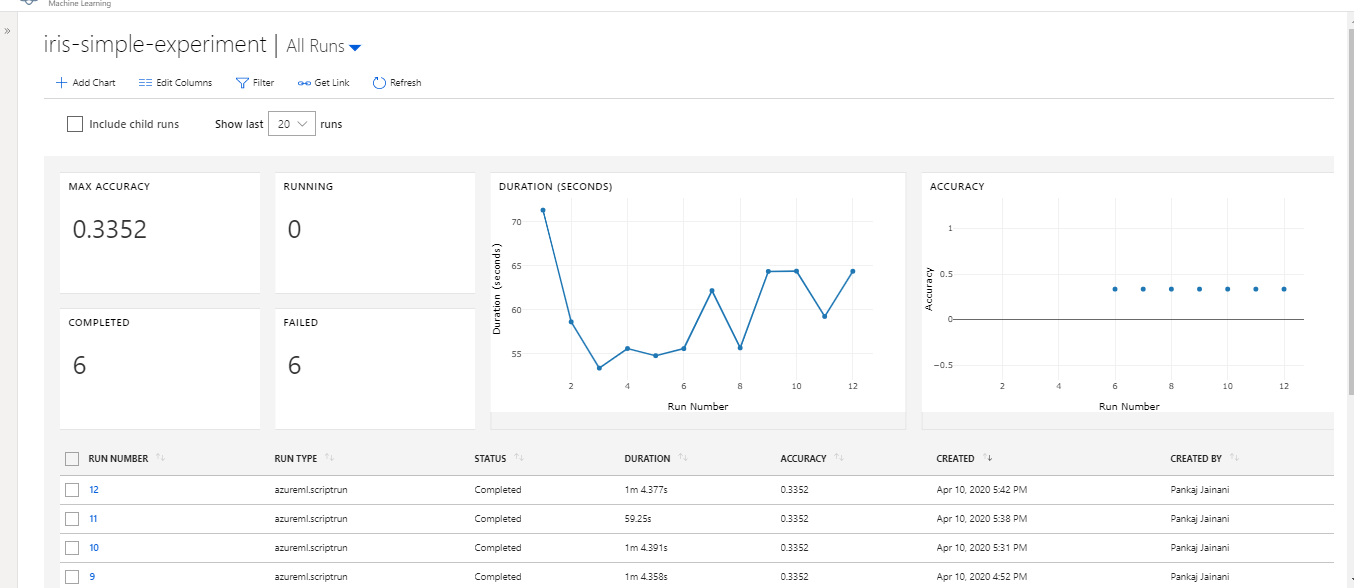

### Experiment's Output
Observe the model file in pickle(pkl) format.
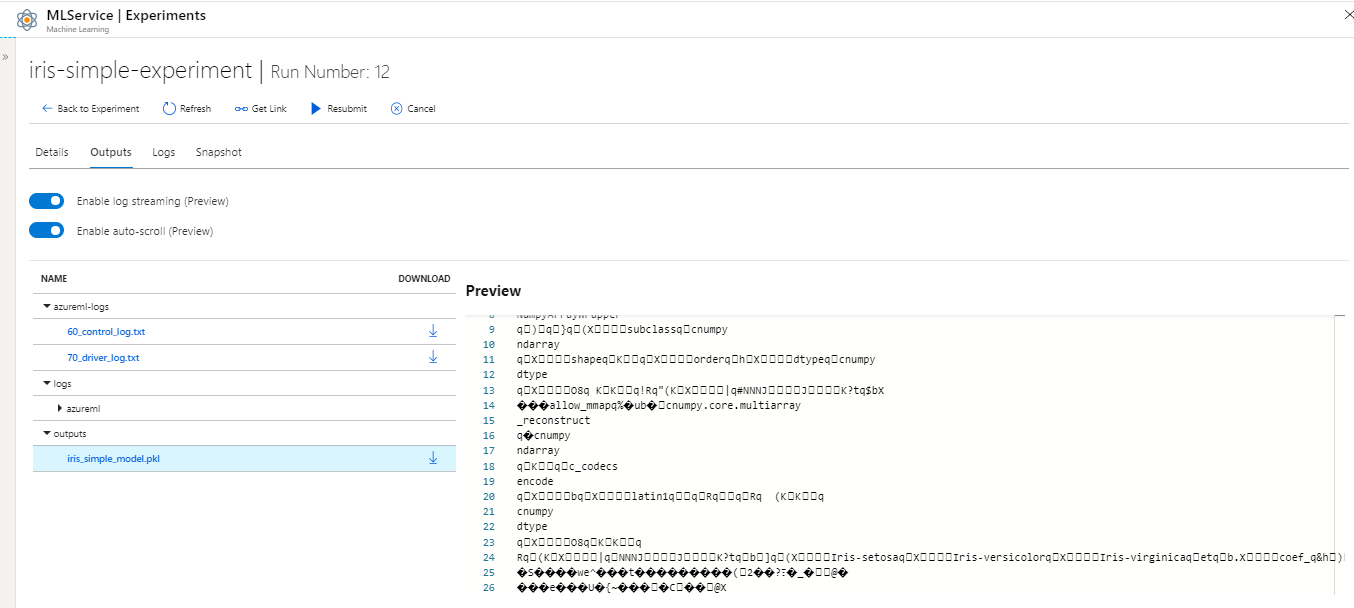

### Snapshot
Details of files uploaded in the folder. 
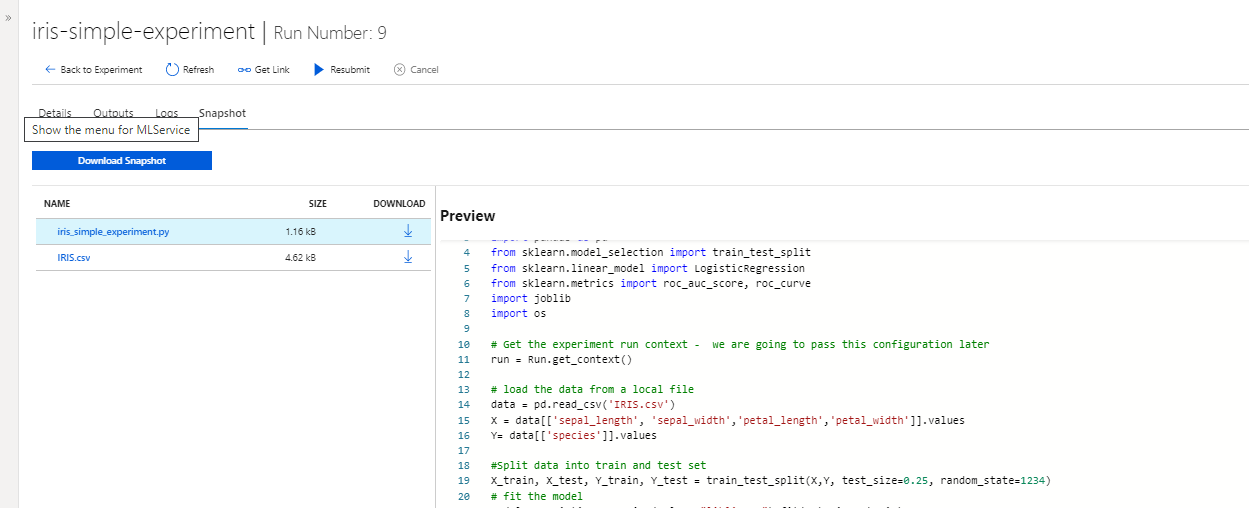



### What Next - 
In the next few notebooks I will look into more advance concepts of Azure Machine learning service API
* Estimatior API  - Which will be used to encapsulate both RunConfiguration and ScriptRunConfiguration in single object.
* Estimator API support various kind of python frameworks Scikit-Learn, Tensorflow, PyTorch.
* Parameterize the Experiment Script to pass runtime values of the model variables.
* Registering model in Azure ML for later infrencing.